# Automation and Harassment Detection
### A code companion for book chapter of the same name

What features of the data could we use to classify comments?  Human languages have typically have large vocabularies in which most words are rare (usage tends to follow the Zipf distribution); we want words that are reasonably specific to harassment but also as common as possible.  The $ \chi^{2} $ test - `sklearn.feature_selection.chi2` - is a really useful statistical test which we can use to search for tokens whose distribution varies between the classes.

In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
from sklearn.feature_selection import chi2


file_name = "../data/attack_train.csv"

raw_samples = pd.read_csv(file_name)
vectorizer = CountVectorizer(lowercase=True,stop_words='english')
X_counts = vectorizer.fit_transform(raw_samples["comment"])

# We need to be able to lookup counts for a given word.  We'll make a dictionary to help with that
word_to_feature_index = dict(zip(vectorizer.get_feature_names(), range(0, len(vectorizer.get_feature_names()))))

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X = X_tfidf
chi2score = chi2(X,(raw_samples["attack"] > 0).astype(bool)) [0]

wscores = zip(vectorizer.get_feature_names(),chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1]) 
topchi2 = zip(*wchi2[-50:-25])
list(topchi2)[0]

('loser',
 'section',
 'ur',
 'bullshit',
 'bastard',
 'penis',
 'people',
 'attacks',
 'fag',
 'dumb',
 'troll',
 'die',
 'continue',
 'pathetic',
 'don',
 'warning',
 'shut',
 'moron',
 'kill',
 'image',
 'welcome',
 'cock',
 'racist',
 'crap',
 'article')

In [20]:
attack = np.asarray(raw_samples['attack'])
#np.sum(X[attack <0.1,moron_i] > 0)

word_list = ['personal','block','vandalize','life','attack','thanks','hate','faggot','vandalism','hell','dick','cunt','blocked','idiot', 'asshole','gay','redirect','suck','bitch','ass','stupid','shit','stop','fucking','fuck']
word_list.extend(['loser', 'bullshit','penis', 'fag','dumb','troll','die','pathetic','shut','moron','kill','cock','racist','crap'])

benign_score = []
attack_score = []
for word in word_list:
    word_index = word_to_feature_index[word]
    benign_count = np.sum(X[attack <0.1,word_index] > 0)
    attacking_count = np.sum(X[attack > 0.4,word_index] > 0)
    benign_score.append(benign_count)
    attack_score.append(attacking_count)
    #print(word + " was in " + str(benign_count) + " benign comments and " + str(attacking_count) + " attacking comments.")
    

d = {"Word": word_list, "Benign Comments": benign_score, "Attack Comments": attack_score}    
df_word_counts = pd.DataFrame(d)
df_word_counts.to_csv("attacking_word_counts.csv")
print(df_word_counts)
print("There were " + str(np.sum(attack < 0.1)) + " very benign comments and " + str(np.sum(attack > 0.4)) + " attacking comments")    

    Attack Comments  Benign Comments       Word
0               350              780   personal
1               454              558      block
2                83              111  vandalize
3               575              498       life
4               234              294     attack
5               227             2763     thanks
6               250               84       hate
7               223                1     faggot
8               311              559  vandalism
9               310               79       hell
10              303               20       dick
11              262                1       cunt
12              420              699    blocked
13              355                6      idiot
14              326                1    asshole
15              308               39        gay
16               13              791   redirect
17              373                5       suck
18              401                1      bitch
19              514               10    

In [21]:
insults = ["faggot","dick","cunt","idiot","asshole","gay","suck","bitch","ass","stupid","shit","fucking","fuck"]
insults.extend(['loser', 'bullshit','penis', 'fag','dumb','troll','die','pathetic','shut','moron','kill','cock','racist','crap'])
scores = []
for i in range(0, X.shape[0]):
    score = 0
    for token in insults:
        token_index = word_to_feature_index[token]
        if X[i, token_index] != 0:
            score = score + 1
            
    scores.append(score)
    
d = {"scores": scores, "attack":raw_samples["attack"]}
df = pd.DataFrame(d)

Text(0.5,0,'Insult count')

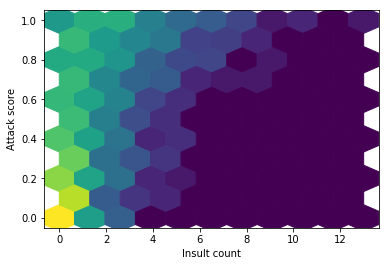

In [22]:
fig = plt.hexbin(df["scores"], df["attack"], gridsize=10, bins='log')
plt.ylabel("Attack score")
plt.xlabel("Insult count")

Text(0.5,1,'Scores for comments with attack score > 0.4')

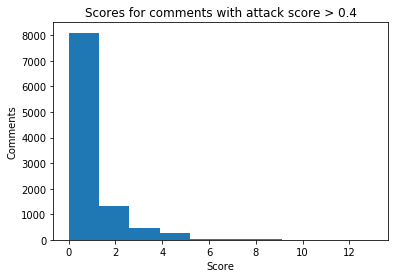

In [23]:
plt.hist(df[df["attack"] > 0.4]["scores"])
plt.ylabel("Comments")
plt.xlabel("Score")
plt.title("Scores for comments with attack score > 0.4")

In [24]:
df_attack = df[df["attack"] > 0.4] 
df_detected = df_attack[df_attack["scores"] > 0]
true_positive = df_detected.shape[0]
attack_count = df_attack.shape[0]
print("Attacks caught: " + str(true_positive))
print("Total comments with attack > 0.4: " + str(attack_count))
print("Recall: " + str(true_positive / attack_count))

Attacks caught: 5532
Total comments with attack > 0.4: 10201
Recall: 0.5422997745319086


In [25]:
df_benign = df[df["attack"] < 0.1] 
df_detected = df_benign[df_benign["scores"] > 0]
false_positive = df_detected.shape[0]
benign_count = df_benign.shape[0]
print("Benign comments flagged: " + str(false_positive))
print("Total benign comments with attack < 0.1: " + str(benign_count))
print("False positive rate: " + str(false_positive / df.shape[0]))

Benign comments flagged: 402
Total benign comments with attack < 0.1: 36647
False positive rate: 0.005782009607916463


(array([36647., 11863.,  7939.,  1522.,  2225.,  2762.,  1457.,   661.,
         1509.,  2941.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

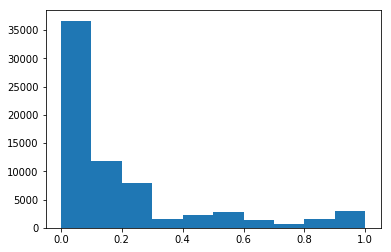

In [26]:
plt.hist(raw_samples["attack"])


In [27]:
very_nice = raw_samples["attack"] < 0.1
horrid = raw_samples["attack"] > 0.4
X.shape

(69526, 115605)

In [28]:
raw_samples[horrid][["comment", "attack"]].head()

most_horrid = raw_samples[horrid][["comment"]].iloc[:5]
most_horrid['comment'].tolist()

['  Iraq is not good  ===  ===  USA is bad   ',
 '  ____ fuck off you little asshole. If you want to talk to me as a human start showing some fear the way humans act around other humans, because if you continue your beligerant campaign, i will cross another boundary and begin off-site recruitmehnt.   I can escalate till I am rhetorically nuclear with the whole goddamed mob of you if that is where you think you will find what you want.   You had better start expressing some interest in the concerns presented to you or your credibility as either a document or a community will be about that of a pile of shit.',
 'i have a dick, its bigger than yours! hahaha',
 "  :get the damn chronology correct.  I don't think your tone is appropriate, and I do not appreciate it.  ",
 '  == renault ==  you sad little bpy for driving a renault clio which has no vaa voom so there and the mcflurry is made of shit']

In [29]:
raw_samples[very_nice][["comment"]].head()
nicest = raw_samples[very_nice][["comment"]].iloc[:5]
nicest['comment'].tolist()

['"- This is not ""creative"".  Those are the dictionary definitions of the terms ""insurance"" and ""ensurance"" as properly applied to ""destruction"".  If you don\'t understand that, fine, legitimate criticism, I\'ll write up ""three man cell"" and ""bounty hunter"" and then it will be easy to understand why ""ensured"" and ""insured"" are different - and why both differ from ""assured"".  The sentence you quote is absolutely neutral.  You just aren\'t familiar with the underlying theory of strike-back (e.g. submarines as employed in nuclear warfare) guiding the insurance, nor likely the three man cell structure that kept the IRA from being broken by the British.  If that\'s my fault, fine, I can fix that to explain.  But ther\'es nothing ""personal"" or ""creative"" about it.  I\'m tired of arguing with you.  Re: the other article, ""multi-party"" turns up plenty, and there is more use of ""mutually"" than ""mutual"".  If I were to apply your standard I\'d be moving ""Mutual Assure

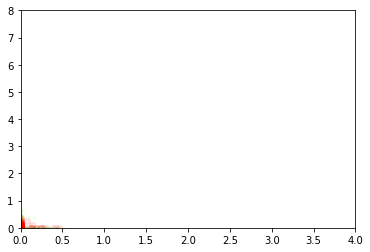

10201

In [30]:
nicest = raw_samples[very_nice][["comment", "attack"]].index
horridest = raw_samples[horrid][["comment", "attack"]].index

moron_i = word_to_feature_index['moron']

x = np.asarray(X[nicest,0].todense()).tolist()
y = np.asarray(X[nicest,1].todense()).tolist()

ax = plt.subplot()
ax.scatter(x, y, marker='^', color=(0,1,0,0.05), s=10)
ax.set_xlim(0, 4)
ax.set_ylim(0, 8)
#plt.hexbin(x,y,bins='log', gridsize=10)

x = np.asarray(X[horridest,0].todense()).tolist()
y = np.asarray(X[horridest,1].todense()).tolist()
ax.scatter(x, y,marker='o', color=(1,0,0,0.1))
# Show the boundary between the regions:
#plt.hexbin(x,y,bins='log')

plt.show()
len(x)

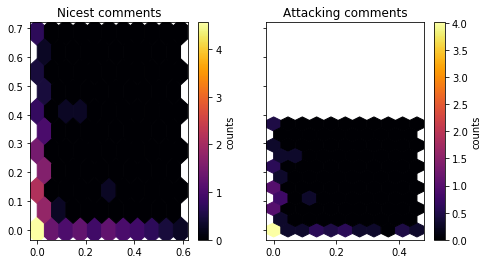

In [31]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(7, 4))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]

x = np.asarray(X[nicest,0].todense()).tolist()
y = np.asarray(X[nicest,1].todense()).tolist()

hb = ax.hexbin(x, y, gridsize=10, bins='log',cmap='inferno')
ax.set_title("Nicest comments")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

ax = axs[1]

x = np.asarray(X[horridest,0].todense()).tolist()
y = np.asarray(X[horridest,1].todense()).tolist()

hb = ax.hexbin(x, y, gridsize=10, bins='log', cmap='inferno')
ax.set_title("Attacking comments")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

In [32]:
moron_i = word_to_feature_index['moron']

# Classifiers!
Let's use tf-idf to build our first classifier!  First, we'll remind ourselves of what the data looks like...

In [33]:
raw_samples.head()

,rev_id,comment,year,logged_in,ns,sample,split,attack
0,37675,"""- This is not """"creative"""". Those are the di...",2002,False,article,random,train,0.0
1,44816,""" :: the term """"standard model"""" is itself le...",2002,False,article,random,train,0.0
2,49851,"True or false, the situation as of March 200...",2002,False,article,random,train,0.0
3,93890,This page will need disambiguation.,2002,True,article,random,train,0.0
4,102817,- Important note for all sysops: There is a ...,2002,True,user,random,train,0.0


To train a binary classifer (harassment or not) we need to pick a cut-off: how high an "attack" value is too high?  Sometimes a histogram can help us decide. Where should we make the cut-off?  We can see that the value of 0.4 chosen for the article excludes a lot of comments.

Text(0.5,0,'Attack probability')

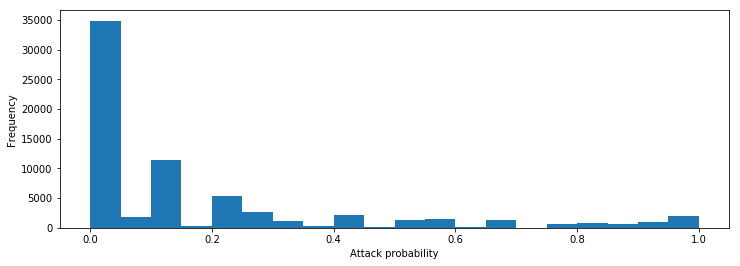

In [55]:
raw_samples["attack"].plot.hist(bins=20)
plt.xlabel("Attack probability")

We make our labels by turning our attack variable into a binary label...

In [35]:
labels = raw_samples["attack"] > 0.4
num_true = len(labels[labels == True])
num_false = len(labels[labels == False])
print("We have " + str(num_true) + " examples of attacks and " + str(num_false) + " examples of benign comments")

We have 10201 examples of attacks and 59325 examples of benign comments


Let's split out dataset into two parts - one to train our model, and one to evaluate it afterwards.  We'll use random selection to split into 80% train, 20% test.

In [36]:
import numpy as np

train_mask = np.random.rand(X.shape[0]) < 0.8
train_X = X[train_mask]
train_Y = labels[train_mask]
test_X = X[~train_mask]
test_Y = labels[~train_mask]

Now we can finally train and evaluate a model!

In [37]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_X, train_Y)

Y_hat = logreg.predict(test_X)

How good is the model?  That is hard to capture in a single number, so we'll use a few different metrics.

In [38]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, classification_report

def evaluate_model(mdl, test_X, test_Y, has_proba=False):
    Y_hat = mdl.predict(test_X)
    precision = precision_score(test_Y, Y_hat)
    recall = recall_score(test_Y, Y_hat)
    accuracy = accuracy_score(test_Y, Y_hat)

    print(classification_report(test_Y, Y_hat))
    if has_proba == True:
        binary_cross_entropy = log_loss(Y_hat, mdl.predict_proba(test_X))
        print("Binary cross entropy:" + str(binary_cross_entropy))    
        
    #print("Precision:" + str(precision))
    #print("Recall:" + str(recall))
    #print("Accuracy:" + str(accuracy))

evaluate_model(logreg, test_X, test_Y, True)


             precision    recall  f1-score   support

      False       0.93      0.93      0.93     11952
       True       0.60      0.61      0.60      2002

avg / total       0.89      0.88      0.88     13954

Binary cross entropy:0.013956290676745055


In [41]:
import xgboost as xgb
    
    
xgb_model = xgb.XGBClassifier(n_jobs=4)
xgb_model.fit(train_X, train_Y)

evaluate_model(xgb_model, test_X, test_Y, False)

             precision    recall  f1-score   support

      False       0.90      1.00      0.95     11952
       True       0.94      0.37      0.53      2002

avg / total       0.91      0.91      0.89     13954



/home/ed/miniconda3/envs/idp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Is that the best we can do with decision trees?  Let's do a little fine-tuning:

In [42]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import pickle 
clf = GridSearchCV(xgb_model,{'max_depth': [2,4,6],'n_estimators': [5,10,20]}, verbose=1)
#clf.fit(train_X,train_Y)

#print("Lowest loss: " + str(clf.best_score_) + "\n")
#print(clf.best_params_)

#print("Saving best model to best_xgb.mdl\n")
#pickle.dump(clf.best_estimator_, open("best_xgb.mdl", "wb"))

In [ ]:
#evaluate_model(clf.best_estimator_, test_X, test_Y, True)

Time to try our classifiers on another dataset (Reddit). To smooth the processing of new text inputs, we'll create a "pipeline" that encapsulates all the pre-processing we need to do.

In [44]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', vectorizer),
                      ('tfidf', tfidf_transformer),
                      ('clf', xgb_model)])

Now we need to open the data.  The comments are stored in JSON format, and have been organized by subreddit.  For now, let's concentrate on two particular subreddits - "Rangers" (ice hockey) and "Personal finance" (what it sounds like).

In [45]:
import json

reddit_comments = None
with open("comments_by_reddit.json") as fh:
    reddit_comments = json.load(fh)

rangers = reddit_comments["rangers"]
personal_finance = reddit_comments["personalfinance"]

Now that we have two lists of comments to work with, we can try doing some classification...

In [46]:
def create_results_table(list_of_comments, model):
    is_attack = model.predict_proba(list_of_comments)[:,1]
    
    data = {"attack_probability": is_attack, "comment": list_of_comments}
    df_result = pd.DataFrame(data)
    df_result = df_result.sort_values(by='attack_probability', ascending=False)
    
    return (df_result)
    
df_rangers = create_results_table(rangers, text_clf)

Now we have a sorted dataframe, we can look at some of the most "attacking" comments, as rated by our model...

In [47]:
from IPython.display import display, HTML

def print_table(df):
    pd.set_option('max_colwidth', 300)
    pd.options.display.float_format = '{:,.2f}'.format
    display(HTML(df.to_html(index=False)))

print_table(df_rangers.head(n=10))

attack_probability,comment
0.99,How do you hop on the guys dick that just got fucking wrecked by kreiders skill skating? that confuses the fuck out of me
0.97,Stop fucking passing it in the slot. holy fuck
0.96,jesus fuck just put it on the fucking net
0.94,One thing we have to do in this series. ONE FUCKING THING. STAY OFF THE GOD DAMN PENALTY KILL
0.94,It's the same fucking spot every goddamn fucking time. how can no one stop that fucker. goddammit grandpa boyle
0.93,shut the fuck up pierre.
0.93,holy fucking shit
0.92,"fuck you pierre! god damn, that just doesnt look the same without the capslock"
0.91,"holy shit was that a frustrating period. can't connect on passes, can't control the puck, players look like they're half asleep and hungover from the pitt series. msg is quiet as fuck. \n\nwe just don't want it yet. hope av has some words of wisdom for the period break."
0.91,our handle is amazingly bad this game. every time we skate with the puck we lose it because of some stupid ass mishandle. very frustrating to watch


What about the least?

In [48]:
print_table(df_rangers.tail(n=10))

attack_probability,comment
0.11,"Who is announcing the game, his style seems to be just calling out names. Not a fan."
0.11,This guy rules. http://imgur.com/ktGj08v
0.11,no goalie ever seems to make that save... so frustrating.
0.11,"They will come out flying. Av is going to perform more mystical coaching voodoo, you just wait....\n \nAlso Hank will give them that disapproving look that makes men ashamed and strive for excellence."
0.11,those don't look like the type of people who would be ordering two feet of pizza
0.11,we defiantly deserved a goal this period
0.11,"Dan boyle, the words I have for you ... dear god they aren't pretty."
0.10,thank you nbcsn... it is possible to fall asleep in your chair during playoff hockey. is it too much to ask from maybe a little tiny bit of excitement from your broadcast? maybe we should get gary thorn to do nantz impressions.
0.08,thanks!
0.07,you can hear the lgr ranger's chant trying to start from the 300s section


For comparison, let's look at personal finance, nastiest first:

In [49]:
df_personal_finance = create_results_table(personal_finance, text_clf)
print_table(df_personal_finance.head(n=10))

attack_probability,comment
0.87,18% car loan? What the fuck. Do you never pay your debts or did you just sign a loan without looking at the fine print?
0.66,"Definitely junk food gotta go grocery shopping and use coupons. apply for help from the state, get food stamps. Its always the junk food that costs the most. The average wages life sucks ass and has plenty of paperwork to stay comfortable."
0.50,I used to have very bad anxiety. I went and talked to a physiologist who made me realise no one else actually gives a shit about what I do so why should I worry. Getting help is the best thing.
0.45,"Realistically, most of the regular, reliable audio engineer gigs out there are for megachurches. Unless the congregation &gt;10k every sunday, they don't pay shit. \n\nYou might score the odd recording gig or maybe doing the tech behind indie film scoring or folio work, but other than that there..."
0.36,"jpoysti bought two jet skis, a Martin guitar, and week-long trip to Hawaii with the $15,000 he saved by buying a $10,000 car instead of a $25,000 car. He had $6,000 left over.\n\nHe took that $6,000 invested in for 30 years at 5% and now it's worth $34,000 - which allowed him to retire 5 months..."
0.36,"Just be careful about food. I justified moving out as being cheaper because splitting the rent 4 ways and no expensive-ass meal plan meant a big chunk of savings. However, with house-mates never keeping the kitchen clean, and not having a lot of confidence or experience cooking even basic meals,..."
0.25,And I probably hate yours :)
0.21,It's a lot more complicated than just living there for a year or two. You need to transfer your whole life over and make enough money to support yourself for that time.\n\nhttp://registrar.berkeley.edu/establish.html?no_server_init
0.21,"I dont understand either. It's like the apex of your life is working that job, for real? I can kind of understand if it's your own company because then you get into your personal legacy which some care about but if it's someone else's name on the building I don't understand how people get so obs..."
0.20,"From a lot of reading I've done on LinkedIn and other employer/business sites, almost all employers will actually give you a higher salary temporarily if you try to force them to give you a raise and then immediately start looking for your replacement. It's kind of a damned if you do, damned if ..."


And the nicest?

In [50]:
print_table(df_personal_finance.tail(n=10))

attack_probability,comment
0.10,"The trickiest parts I've found with self check out: bringing your own reusable bags, buying produce, buying marked down items, and buying alcohol/restricted items.\n\nThere's some simple steps to avoid issues with these, but mainly, figuring out produce was the hard one for me. If it doesn't h..."
0.09,"I actually used to suffer from this. I still do, especially when clothes shopping. Too many options. Between advertisements and staff asking you questions, it feels like a lot of pressure. What helped is education and exposure. \n\neducation: I knew what I was going in for when I would go it. Th..."
0.08,"I understand your point and my friend has raised this issue as well. I will be sure to keep it in mind.\n\nI am going to see how that works. I am about 10 min from my office and where I am working is pretty relaxed, so hopefully it will be doable. Thank you for the advice!"
0.08,"Agreed with Uptown. Luckily Dallas is starting the trolleys again in May and it runs right by my building, so I can go to Uptown for free. I'm not opposed to driving. Thank you for the info!"
0.08,"Lol you do raise a valid point. I do understand living in my means. \n\nSocal rents are ridiculous (grew up in HB), so I didn't think this was over the top for what I wanted. Thank you kind redditor! I will be visiting SoCal this summer, so please let me know if you want me to bring some water :)"
0.08,Thanks for the replies.
0.08,"ah, makes sense - thanks"
0.08,Thanks!
0.08,/r/budgetfood mod here. thanks for the plug!
0.06,Just curious if you've looked at WiseBanyan. They were mentioned in a recent WSJ article about robo-advisors along with the commonly mentioned names.


Hmm... maybe the model is over-relying on "thanks" and "fuck" and doesn't really get the context?  Let's test that idea!

In [51]:
text_clf.predict_proba(["Reader, you fucking rock!  Thank you so much for buying my book!"])[0][1]

0.68625534

Text(0.5,1,'Personal Finance')

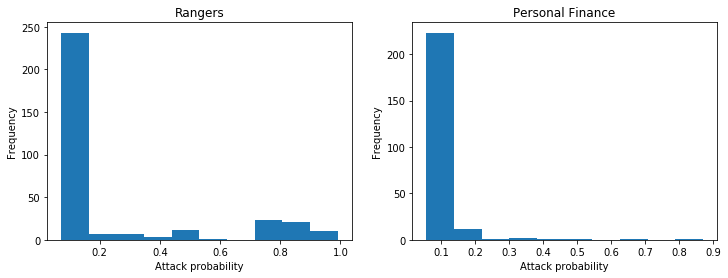

In [52]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 4)
plt.subplot(1, 2, 1)
plt.xlabel("Attack probability")
df_rangers["attack_probability"].plot.hist()
plt.title("Rangers")
plt.subplot(1, 2, 2)
plt.xlabel("Attack probability")
df_personal_finance["attack_probability"].plot.hist()
plt.title("Personal Finance")

Text(0.5,0,'Attack probability')

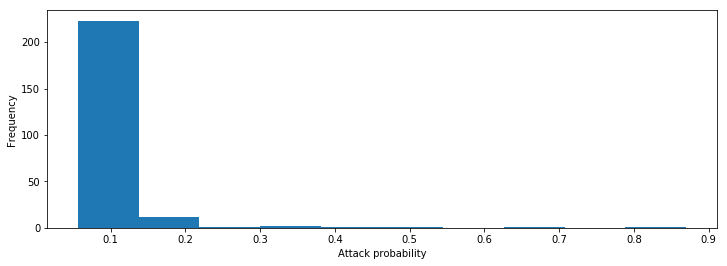

In [54]:
df_personal_finance["attack_probability"].plot.hist()
plt.xlabel("Attack probability")